In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax

# loading data
cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_test = "../data/multilingual_train/test_full_week_{}_non_anon_processed.csv".format("_".join(cc_codes))
test_df = pd.read_csv(filename_pattern_test)

In [4]:
test_df.head()

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,change_s_0_mean,change_s_1_mean,change_p_0_mean,change_p_1_mean,title_s_0,title_p_0,comment_s_0,comment_s_1,comment_p_0,comment_p_1
0,ukwiki,вилучив додаткові пробіли,HutheMeow,575.0,36399189,Grand_Theft_Auto:_Liberty_City_Stories,63,-2,0,2022-07-01 01:55:08.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.782928,1.0,0.014682,-0.198847,0.55318,0.44682
1,ukwiki,[[Help:Cat-a-lot|Cat-a-lot]]: Removing from [[...,Mr.Rosewater,0.0,36399416,Елізабет_Філпот,7,-62,0,2022-07-01 03:52:18.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.293543,1.0,0.014682,-0.198847,0.55318,0.44682
2,ukwiki,додано [[Категорія:Убиті на дуелі]] за допомог...,Mr.Rosewater,445.0,36399659,Еварист_Галуа,140,50,0,2022-07-01 04:35:09.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.076811,1.0,0.014682,-0.198847,0.55318,0.44682
3,ukwiki,"Уточнення щодо розташування, та додаткова інфо...",Ostwik,133803613.0,36400077,Парк_«Чонок»,5,284,0,2022-07-01 05:31:15.0,...,2.511288,-2.375829,0.992513,0.007487,0.836785,1.0,0.014682,-0.198847,0.55318,0.44682
4,ukwiki,NaN,Вальдимар,60.0,36400917,Кабалуд,22,-447,0,2022-07-01 07:44:57.0,...,1.986099,-1.732105,0.976298,0.023702,0.192396,1.0,-1.000000,-1.000000,-1.00000,-1.00000


In [5]:
test_df.wiki_db.value_counts()

enwiki    695938
dewiki    108282
eswiki     92159
ruwiki     83236
plwiki     28168
ukwiki     28024
Name: wiki_db, dtype: int64

In [6]:
len(test_df)

1035807

In [7]:
def is_text_change(df):
    result_list = []
    for i, row in tqdm(df.iterrows()):
        key = False
        for col in ['texts_removed', 'texts_insert', 'texts_change']:
            if ast.literal_eval(row[col]).get("Text", []) != []:
                key = True
        result_list.append(key)
    return result_list

test_df["text_changes_found"] = is_text_change(test_df)

1035807it [03:03, 5630.78it/s]


In [8]:
# rate of revisions with chenges in text
test_df.text_changes_found.mean()

0.5335318259096531

In [9]:
# also the rate of reverts is different
test_df.groupby("text_changes_found").revision_is_identity_reverted.mean()

text_changes_found
False    0.062413
True     0.092446
Name: revision_is_identity_reverted, dtype: float64

In [10]:
# also the rate of reverts is different
test_df.groupby(["wiki_db", "text_changes_found"])[['revision_is_identity_reverted']].agg(["mean", "count"])

revision_is_identity_reverted        
                                                    mean   count
wiki_db text_changes_found                                      
dewiki  False                                   0.030011   44251
        True                                    0.051506   64031
enwiki  False                                   0.061051  337388
        True                                    0.094059  358550
eswiki  False                                   0.108070   40224
        True                                    0.151227   51935
plwiki  False                                   0.039487   13498
        True                                    0.066326   14670
ruwiki  False                                   0.085306   35437
        True                                    0.097638   47799
ukwiki  False                                   0.026429   12373
        True                                    0.036547   15651

In [11]:
feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']
features_actions = ["_".join([old.split("_")[1], old.split("_")[0]]) for old in feat]

features_list = [
       'wiki_db',
       # 'page_title', 
       # 'page_revision_count', 
       'revision_text_bytes_diff',
       'is_mobile_edit', 'is_mobile_web_edit',
       'is_visualeditor', 'is_wikieditor',
       'is_ios_app_edit',
       # 'texts_removed', 'texts_insert', 'texts_change', 'actions',
       # 'categories', 'wikidata_item_id', 
       # 'page_region', 'country_iso_code',
       # 'region_iso_code', 'city', 'latitude', 'longitude',
] + features_actions\
+ [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]] \
+ ["bert_title_score"]

target_column = 'revision_is_identity_reverted'
features = features_list
cat_features = [
    'wiki_db',
    # 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit',
    # 'page_region', 'country_iso_code',
    # 'region_iso_code', 'city'
]

In [12]:
# renaming for convention:

features_renaming = dict()

old_insert = [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]]
new_insert = [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']

features_renaming.update({old: "_".join([old.split("_")[1], old.split("_")[0]]) for old in feat})

new_columns = [features_renaming.get(x, x) for x in test_df.columns]
test_df.columns = new_columns

In [ ]:
model_path = "../title_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-19270"
tokenizer = AutoTokenizer.from_pretrained(
    model_path, truncation=True, max_length=512, device="gpu"
)
model = BertForSequenceClassification.from_pretrained(model_path).to("cuda")
pipe = pipeline(
    task="text-classification", model=model, tokenizer=tokenizer, batch_size=1, device=0
)

test_df.page_title = test_df.page_title.apply(lambda x: str(x).replace("_", " "))

text_to_process = test_df.page_title.unique()
text_features_inter = pipe(
        list(text_to_process),
        return_all_scores=True,
        function_to_apply="none",
        truncation=True,
        max_length=512,
        batch_size=1000,
)
text_features = {text: a[0]['score'] for text, a in zip(text_to_process, text_features_inter)}
test_df["bert_title_score"] = test_df.page_title.apply(lambda x: text_features[x])

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


# Modeling:

In [18]:
model = CatBoostClassifier().load_model("classifier")

# Hold-out validation

- actions features 0.6823 ->  0.7091 (baseline)


In [19]:
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

In [20]:
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.47407103314738125,
 'AUC': 0.7882869213243798,
 'Precision': 0.26244221207544244,
 'Recall': 0.6042710320635116,
 'F1': 0.3659485473892991,
 'Accuracy': 0.8039654826655607}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,954562.0,0.332246,0.179870,0.001813,0.203232,0.299915,0.438642,0.996852
1,81245.0,0.577757,0.237961,0.008934,0.384546,0.579834,0.765263,0.999883


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

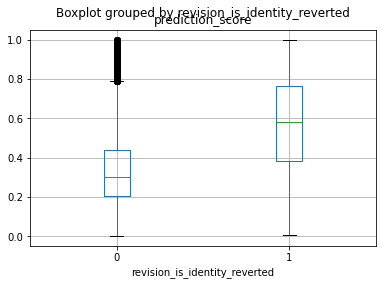

In [21]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


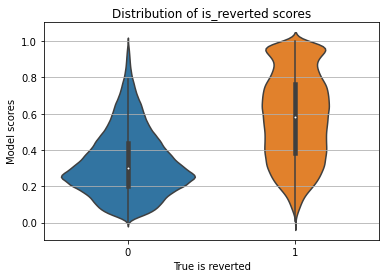

In [22]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

# Balanced hold-out

In [23]:
hold_out_data = Pool(
    data=test_df[test_df.is_balanced == 1][features].fillna(-1),
    label=test_df[test_df.is_balanced == 1][target_column],
    cat_features=cat_features
)
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.576571270970826,
 'AUC': 0.7753213612266736,
 'Precision': 0.7949902798629808,
 'Recall': 0.6042710320635116,
 'F1': 0.6866331439291588,
 'Accuracy': 0.6976145267808347}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,81245.0,0.346744,0.176603,0.002534,0.219307,0.313009,0.450673,0.995861
1,81245.0,0.577757,0.237961,0.008934,0.384546,0.579834,0.765263,0.999883


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


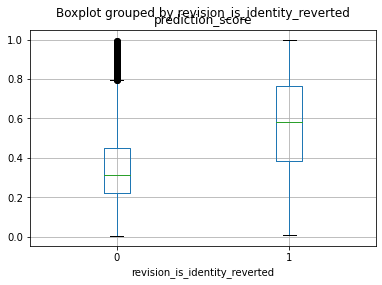

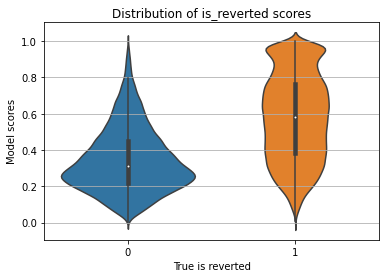

In [24]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[test_df.is_balanced == 1][target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

## Analysing performance per country:

In [27]:
wikidbs = ['enwiki', 'ukwiki', 'ruwiki', 'eswiki', 'dewiki']
results = []
for wbd in wikidbs:

    hold_out_data = Pool(
        data=test_df[(test_df.wiki_db == wbd)][features].fillna(-1),
        label=test_df[(test_df.wiki_db == wbd)][target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    results.append(metrics_holdout)


print("Results on imbalanced data")
res_table = pd.DataFrame(results)
res_table["wiki_db"] = wikidbs
revert_rate = test_df.groupby("wiki_db")[target_column].mean().to_dict()
res_table["original_revert_rate"] = res_table["wiki_db"].apply(lambda x: revert_rate.get(x))
res_table

Results on imbalanced data


,Logloss,AUC,Precision,Recall,F1,Accuracy,wiki_db,original_revert_rate
0,0.522463,0.771930,0.233796,0.611067,0.338197,0.777170,enwiki,0.078057
1,0.176630,0.829108,0.486877,0.307008,0.376566,0.960694,ukwiki,0.032080
2,0.458896,0.810198,0.332460,0.654226,0.440878,0.817552,ruwiki,0.092388
3,0.522303,0.792186,0.357612,0.662651,0.464531,0.761303,eswiki,0.132391
4,0.244543,0.804953,0.391058,0.374406,0.382551,0.937906,dewiki,0.042722


In [32]:
wikidbs = ['enwiki', 'ukwiki', 'ruwiki', 'eswiki', 'dewiki']
results = []
for wbd in wikidbs:

    hold_out_data = Pool(
        data=test_df[(test_df.is_balanced == 1) & (test_df.wiki_db == wbd)][features].fillna(-1),
        label=test_df[(test_df.is_balanced == 1) & (test_df.wiki_db == wbd)][target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    results.append(metrics_holdout)


print("Results on balanced data")
res_table = pd.DataFrame(results)
res_table["wiki_db"] = wikidbs
revert_rate = test_df.groupby("wiki_db")[target_column].mean().to_dict()
res_table["original_revert_rate"] = res_table["wiki_db"].apply(lambda x: revert_rate.get(x))
res_table

Results on balanced data


,Logloss,AUC,Precision,Recall,F1,Accuracy,wiki_db,original_revert_rate
0,0.575492,0.771864,0.781790,0.611067,0.685966,0.693264,enwiki,0.078057
1,0.771329,0.835150,0.971010,0.307008,0.466516,0.615049,ukwiki,0.032080
2,0.532930,0.811349,0.834141,0.654226,0.733309,0.739115,ruwiki,0.092388
3,0.548458,0.794875,0.788360,0.662651,0.720060,0.717524,eswiki,0.132391
4,0.699346,0.804598,0.930085,0.374406,0.533893,0.641594,dewiki,0.042722


Random model: ROC AUC=0.501
Catboost: ROC AUC=0.788


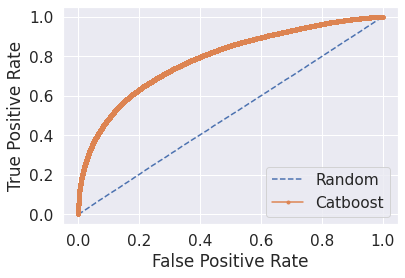

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



testy = test_df[target_column].values
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

lr_probs = model.predict_proba(hold_out_data)[:, 1]
ns_probs = [np.random.uniform() for _ in range(len(testy))]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('Random model: ROC AUC=%.3f' % (ns_auc))
print('Catboost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Catboost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Catboost: f1=0.330 auc=0.360


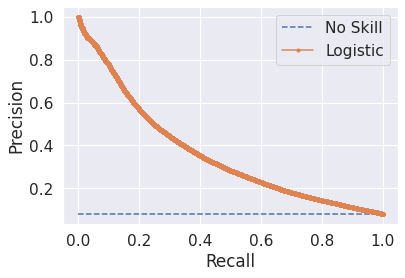

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict class values
yhat = model.predict(hold_out_data)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Catboost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

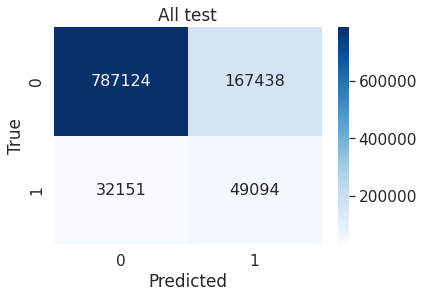

In [35]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_anonymous = confusion_matrix(testy, yhat)

df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g') # font size
plt.title("All test")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 3. Compare performance with Diego's model and ORES

In [56]:
diegos_model_res = pd.read_csv("../data/multilingual_train/test_xgb_proba_full_non_anon.csv")
ores_model_res = pd.read_csv("../data/multilingual_train/test_full_ores_res_non_anon.csv")

diegos_model_res_dict = {rid: score for rid, score in zip(diegos_model_res.revision_id, diegos_model_res.xgb_pred_proba)}
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}

In [57]:
hold_out_data = Pool(
    data=test_df[features_list].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

test_df["catboost_pred"] = model.predict_proba(hold_out_data)[:, 1]
test_df["ores_pred"] = test_df.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df["xgb_pred"] = test_df.revision_id.apply(lambda x: diegos_model_res_dict.get(x)).fillna(-1)

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

threshold = 0.5

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
# df_to_plot = test_df
print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.8071623767213215
Xgboost model accuracy:  0.7353146977700427
ORES model accuracy:  0.8929103945935493
--------------------------------------------------
Catboost model AUC:  0.7888392575533782
Xgboost model AUC:  0.8514391693012682
ORES model AUC:  0.8271284430678704
--------------------------------------------------
Catboost model F1:  0.3334344780274146
Xgboost model F1:  0.3349731334886828
ORES model F1:  0.39505551762549856


In [60]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.7064965197215777
Xgboost model accuracy:  0.7740719257540604
ORES model accuracy:  0.6760038025264243
--------------------------------------------------
Catboost model AUC:  0.7753487663455395
Xgboost model AUC:  0.8442840756167769
ORES model AUC:  0.8150197378060214
--------------------------------------------------
Catboost model F1:  0.6754503180287562
Xgboost model F1:  0.7888857104141886
ORES model F1:  0.5774948259741352


In [61]:
threshold = 0.5

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & ~test_df.country_iso_code.isna()]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.6886412033890625
Xgboost model accuracy:  0.27195350071522423
ORES model accuracy:  0.6369573519226911
--------------------------------------------------
Catboost model AUC:  0.7585168013030694
Xgboost model AUC:  0.6669306936035915
ORES model AUC:  0.6788352000273847
--------------------------------------------------
Catboost model F1:  0.5315974994644491
Xgboost model F1:  0.411485556724063
ORES model F1:  0.45899204244031827


In [62]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.text_changes_found == True)]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.8080934521392227
Xgboost model accuracy:  0.695360837055971
ORES model accuracy:  0.87219846635293
--------------------------------------------------
Catboost model AUC:  0.8026403998425673
Xgboost model AUC:  0.8443978800431661
ORES model AUC:  0.823509504793456
--------------------------------------------------
Catboost model F1:  0.37745850188310787
Xgboost model F1:  0.3481749922051901
ORES model F1:  0.4181665923501071


# 4. Plot confusion matrix per algorithm / wikibd / featureset

### Confusion matrix per algorithm

In [71]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true, pred, title):
    cm_anonymous = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g') # font size
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

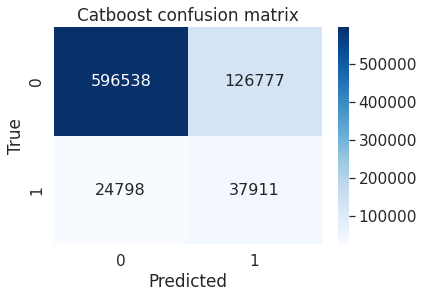

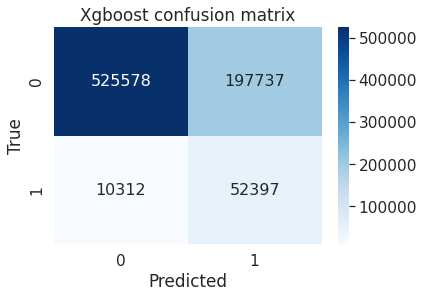

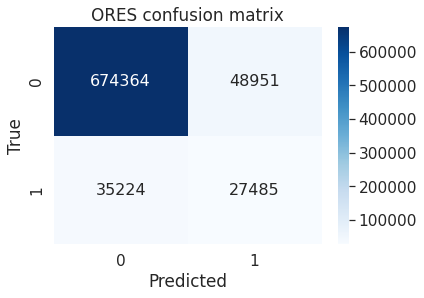

In [72]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]

true = df_to_plot.revision_is_identity_reverted
pred = (df_to_plot.catboost_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Catboost confusion matrix")

pred = (df_to_plot.xgb_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Xgboost confusion matrix")

pred = (df_to_plot.ores_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "ORES confusion matrix")

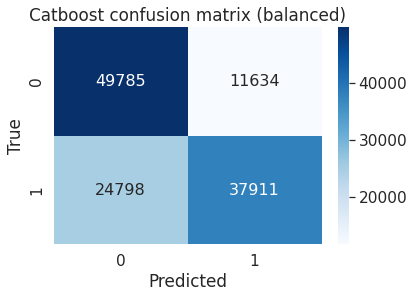

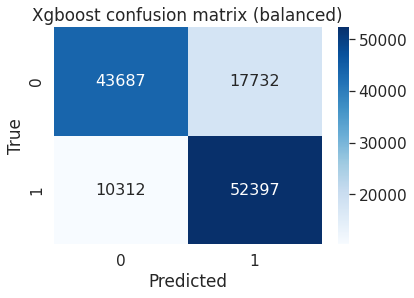

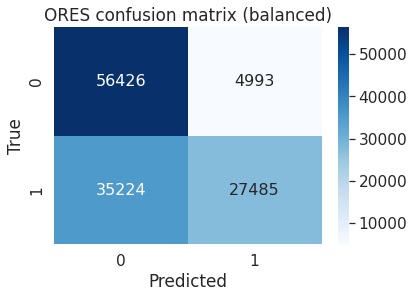

In [73]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]

true = df_to_plot.revision_is_identity_reverted
pred = (df_to_plot.catboost_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Catboost confusion matrix (balanced)")

pred = (df_to_plot.xgb_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Xgboost confusion matrix (balanced)")

pred = (df_to_plot.ores_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "ORES confusion matrix (balanced)")

### Confusion matrix per wikibd

In [74]:
def plot_confusion_matrix(df_to_plot, title=""):
    
    df_to_plot["pred"] = (df_to_plot.catboost_pred > 0.5).astype(int)
    fig, axs = plt.subplots(ncols=len(df_to_plot.wiki_db.unique()), figsize=(35, 5))
    
    for i, wiki_db in enumerate(df_to_plot.wiki_db.unique()):
        
        df_to_plot_tmp = df_to_plot[df_to_plot.wiki_db == wiki_db]
        true = df_to_plot_tmp.revision_is_identity_reverted
        pred = (df_to_plot_tmp.catboost_pred > 0.5).astype(int)
        
        cm_anonymous = confusion_matrix(true, pred)
        df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g', ax=axs[i]) # font size
        axs[i].set_title(wiki_db)
        axs[i].set_xlabel("Predicted")
        axs[i].set_ylabel("True")
    plt.show()

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


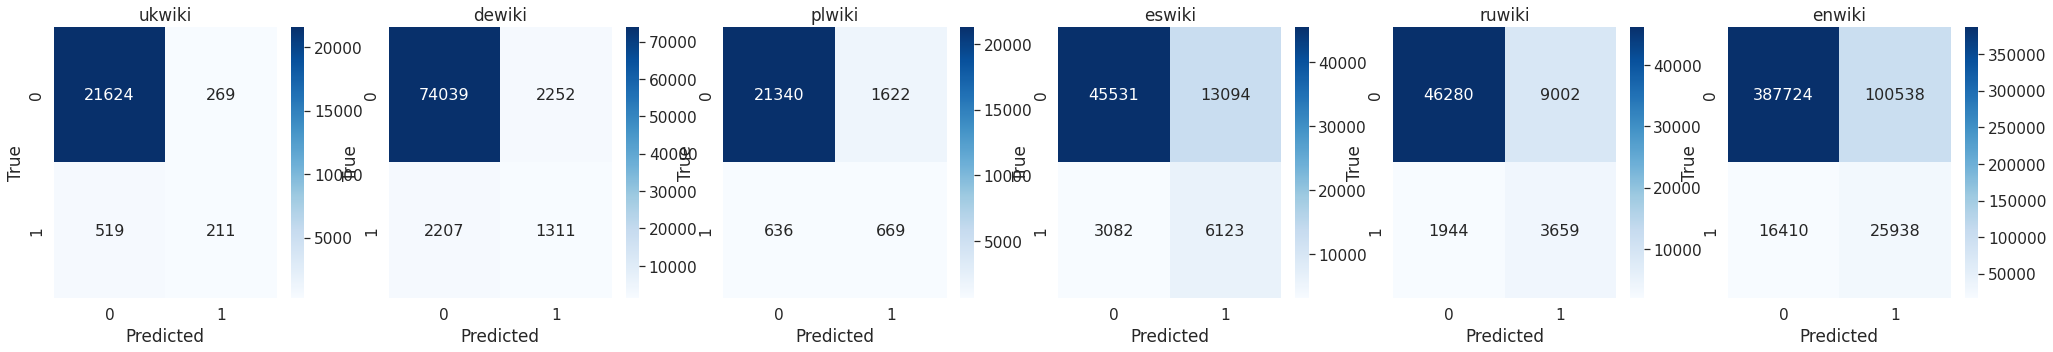

In [75]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
plot_confusion_matrix(df_to_plot)

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


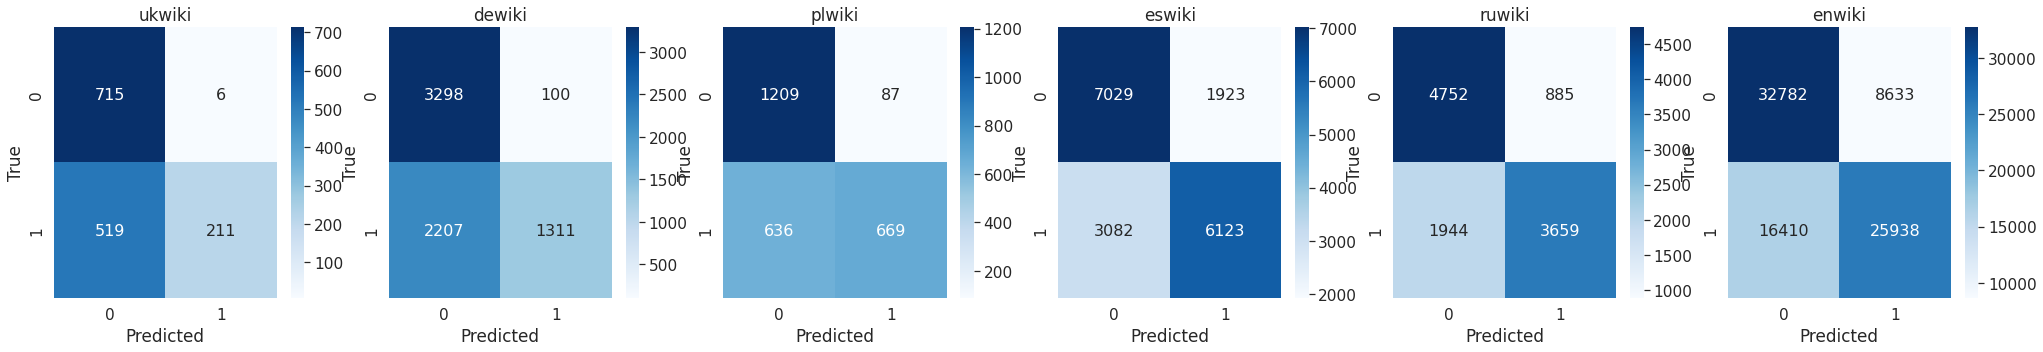

In [76]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]
plot_confusion_matrix(df_to_plot)

# 5. Plot precision-recall curve per algorithm / wikibd / featureset

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from matplotlib.pyplot import figure

def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values

    catboost_probs = df_to_plot.catboost_pred.values
    ores_probs = df_to_plot.ores_pred.fillna(0).values
    xgboost_probs = df_to_plot.xgb_pred.fillna(0).values
    random_probs = [np.random.uniform() for _ in range(len(true_values))]

    # calculate scores
    random_auc = roc_auc_score(true_values, random_probs)
    catboost_auc = roc_auc_score(true_values, catboost_probs)
    ores_auc = roc_auc_score(true_values, ores_probs)
    xgboost_auc = roc_auc_score(true_values, xgboost_probs)

    # summarize scores
    print('Random model: ROC AUC=%.3f' % (random_auc))
    print('Catboost: ROC AUC=%.3f' % (catboost_auc))
    print('ORES model: ROC AUC=%.3f' % (ores_auc))
    print('xgboost: ROC AUC=%.3f' % (xgboost_auc))


    # predict class values
    yhat = model.predict(hold_out_data)

    catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)
    catboost_f1, catboost_auc = f1_score(true_values, catboost_probs>0.5), auc(catboost_recall, catboost_precision)

    ores_precision, ores_recall, _ = precision_recall_curve(true_values, ores_probs)
    ores_f1, ores_auc = f1_score(true_values, ores_probs>0.5), auc(ores_recall, ores_precision)

    xgboost_precision, xgboost_recall, _ = precision_recall_curve(true_values, xgboost_probs)
    xgboost_f1, xgboost_auc = f1_score(true_values, xgboost_probs>0.5), auc(xgboost_recall, xgboost_precision)

    print("_"*50)
    # summarize scores
    print('Catboost: f1=%.3f auc=%.3f' % (catboost_f1, catboost_auc))
    print('ORES: f1=%.3f auc=%.3f' % (ores_f1, ores_auc))
    print('XGBOOST: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(catboost_recall, catboost_precision, marker='.', label='Catboost')
    pyplot.plot(ores_recall, ores_precision, marker='.', label='ORES')
    pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBOOST')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Random model: ROC AUC=0.500
Catboost: ROC AUC=0.789
ORES model: ROC AUC=0.827
xgboost: ROC AUC=0.851
__________________________________________________
Catboost: f1=0.333 auc=0.363
ORES: f1=0.395 auc=0.390
XGBOOST: f1=0.335 auc=0.354


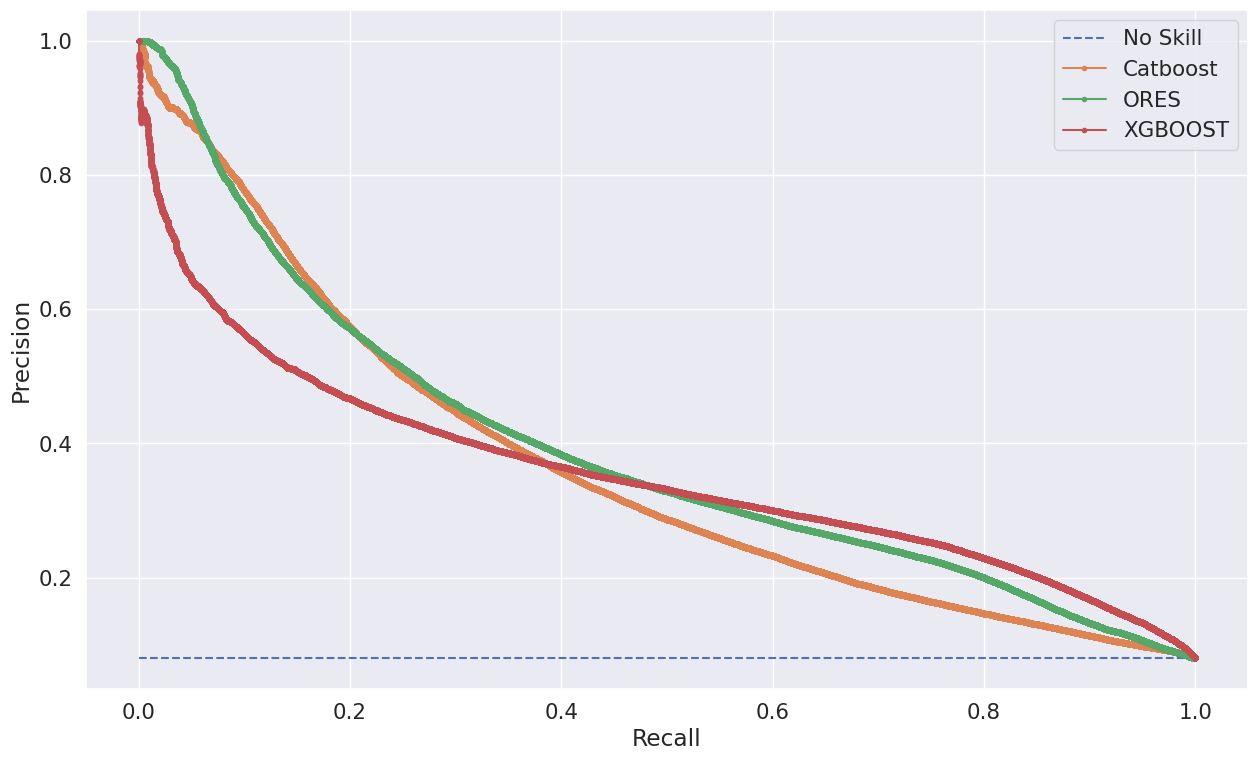

In [78]:
figure(figsize=(15, 9), dpi=100)
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
precision_recall_plot(df_to_plot)

In [79]:
# if treshold is 0.95:
# results interpretation: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.catboost_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.catboost_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.catboost_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.23019892159720198
Recall:  0.6045543701860977
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  164688
Number of items predicted as revert and are really reverts:  37911
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.2644565463679905
Recall:  0.5397470857452679
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  127987
Number of items predicted as revert and are really reverts:  33847
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.30441072362953614
Recall:  0.47313782710615704
Total number o

In [80]:
# if treshold is 0.95:
# results interpretation: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.xgb_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.xgb_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.xgb_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.20947572101353673
Recall:  0.8355578944011226
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  250134
Number of items predicted as revert and are really reverts:  52397
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.22530522136616327
Recall:  0.8072206541325806
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  224673
Number of items predicted as revert and are really reverts:  50620
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.2399209894013768
Recall:  0.7786442137492225
Total number of

ukwiki
Random model: ROC AUC=0.512
Catboost: ROC AUC=0.830
ORES model: ROC AUC=0.862
xgboost: ROC AUC=0.876
__________________________________________________
Catboost: f1=0.349 auc=0.312
ORES: f1=0.298 auc=0.259
XGBOOST: f1=0.247 auc=0.306


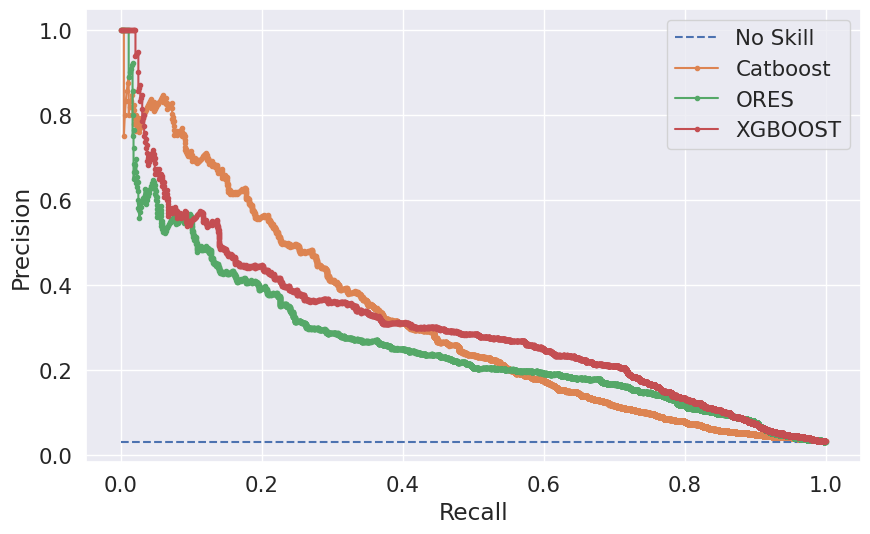

dewiki
Random model: ROC AUC=0.505
Catboost: ROC AUC=0.805
ORES model: ROC AUC=0.856
xgboost: ROC AUC=0.867
__________________________________________________
Catboost: f1=0.370 auc=0.350
ORES: f1=0.364 auc=0.319
XGBOOST: f1=0.311 auc=0.320


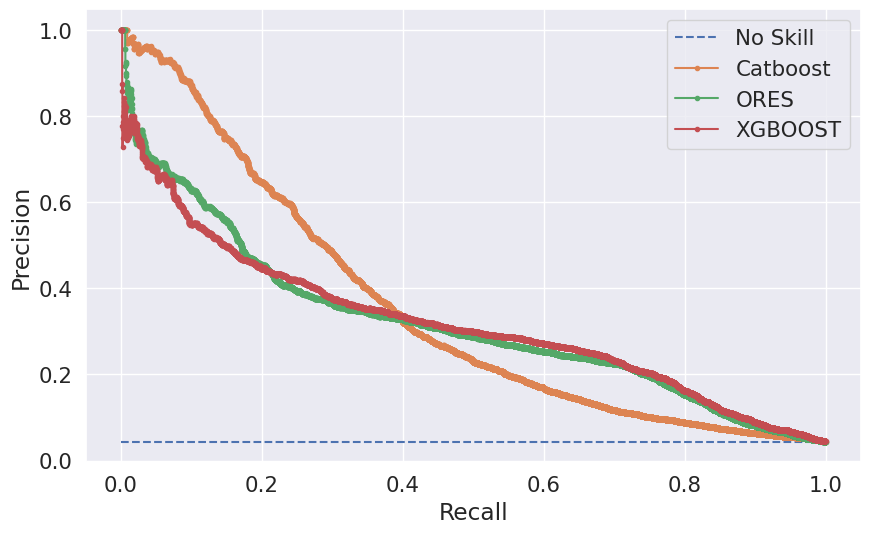

plwiki
Random model: ROC AUC=0.518
Catboost: ROC AUC=0.831
ORES model: ROC AUC=0.835
xgboost: ROC AUC=0.887
__________________________________________________
Catboost: f1=0.372 auc=0.358
ORES: f1=0.276 auc=0.314
XGBOOST: f1=0.351 auc=0.339


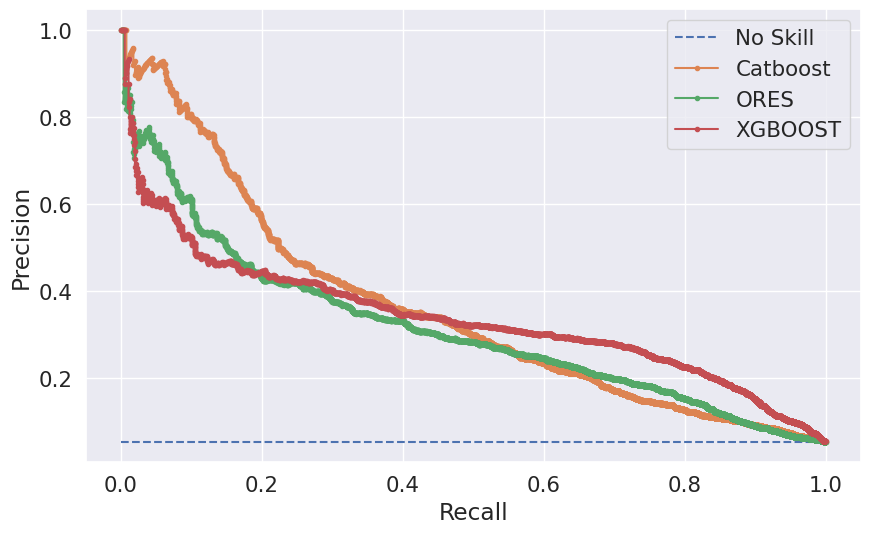

eswiki
Random model: ROC AUC=0.498
Catboost: ROC AUC=0.791
ORES model: ROC AUC=0.873
xgboost: ROC AUC=0.866
__________________________________________________
Catboost: f1=0.431 auc=0.481
ORES: f1=0.494 auc=0.631
XGBOOST: f1=0.447 auc=0.500


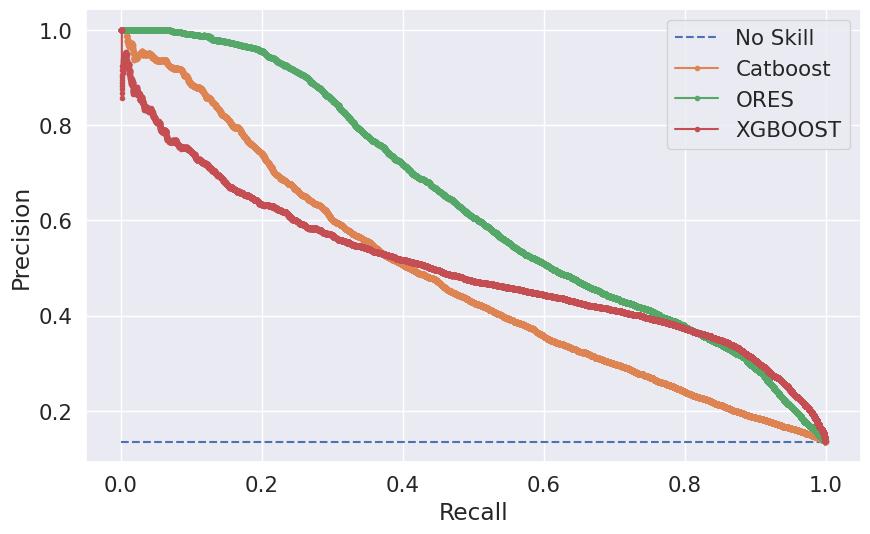

ruwiki
Random model: ROC AUC=0.502
Catboost: ROC AUC=0.811
ORES model: ROC AUC=0.854
xgboost: ROC AUC=0.858
__________________________________________________
Catboost: f1=0.401 auc=0.446
ORES: f1=0.433 auc=0.472
XGBOOST: f1=0.377 auc=0.456


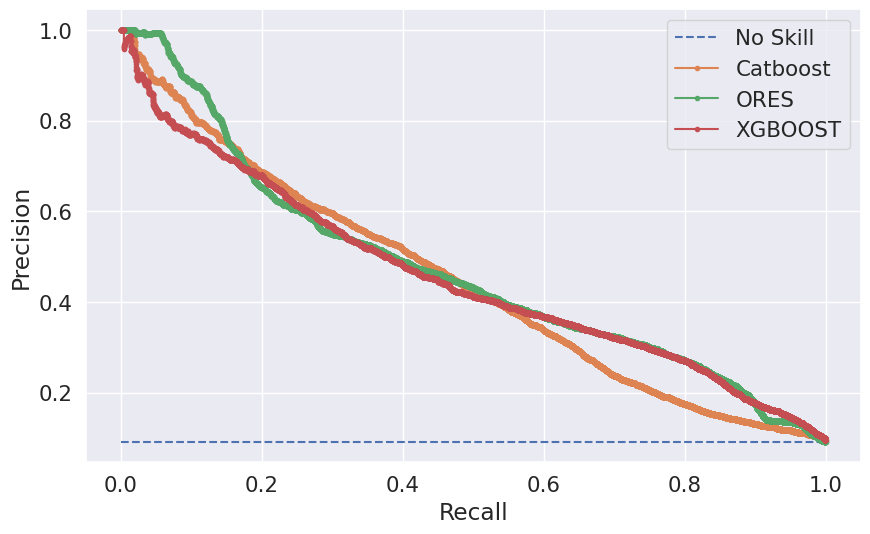

enwiki
Random model: ROC AUC=0.498
Catboost: ROC AUC=0.773
ORES model: ROC AUC=0.816
xgboost: ROC AUC=0.836
__________________________________________________
Catboost: f1=0.307 auc=0.332
ORES: f1=0.354 auc=0.358
XGBOOST: f1=0.315 auc=0.317


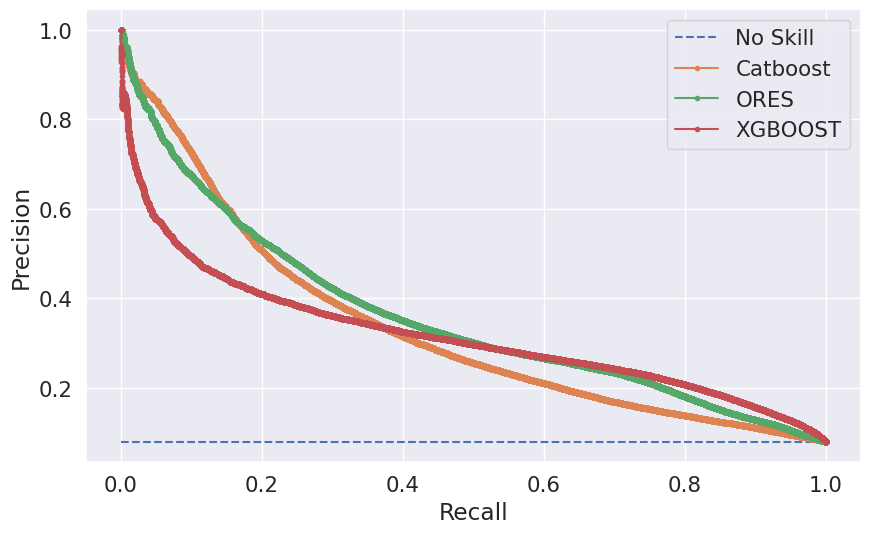

In [82]:
for wiki_db in test_df.wiki_db.unique():
    print(wiki_db)
    df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == wiki_db)]
    figure(figsize=(10, 6), dpi=100)
    precision_recall_plot(df_to_plot)

In [83]:
# results interpretation for ukwiki: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == "ukwiki")]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.catboost_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.catboost_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.catboost_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.4395833333333333
Recall:  0.28904109589041094
Total number of revisions:  22623
Total number of reverts:  730
Number of items predicted as revert (should be reviewed):  480
Number of items predicted as revert and are really reverts:  211
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.4817708333333333
Recall:  0.2534246575342466
Total number of revisions:  22623
Total number of reverts:  730
Number of items predicted as revert (should be reviewed):  384
Number of items predicted as revert and are really reverts:  185
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.5278688524590164
Recall:  0.22054794520547946
Total number of revisions:  226

# 6. Calculate metrics for each day, look how they differ

In [84]:
from sklearn.metrics import roc_auc_score

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]

def get_time_characteristics(df_to_plot):
    
    df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
    
    def compute_accuracy_catboost(df):
        pred = (df.catboost_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_accuracy_ores(df):
        pred = (df.ores_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_accuracy_xgb(df):
        pred = (df.xgb_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_auc_catboost(df):
        score = df.catboost_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_ores(df):
        score = df.ores_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_xgboost(df):
        score = df.xgb_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    cat_acc = df_to_plot.groupby("day").apply(compute_accuracy_catboost)
    ore_acc = df_to_plot.groupby("day").apply(compute_accuracy_ores)
    xgb_acc = df_to_plot.groupby("day").apply(compute_accuracy_xgb)
    cat_auc = df_to_plot.groupby("day").apply(compute_auc_catboost)
    ore_auc = df_to_plot.groupby("day").apply(compute_auc_ores)
    xgb_auc = df_to_plot.groupby("day").apply(compute_auc_xgboost)

    final_df = pd.concat([cat_acc, ore_acc, xgb_acc, cat_auc, ore_auc, xgb_auc], axis = 1)
    final_df.columns = ["accuracy_catboost", "accuracy_ores", "accuracy_xgb", "auc_catboost", "auc_ores", "auc_xgb"]
    
    return final_df

In [85]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
get_time_characteristics(df_to_plot)

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.805133,0.892006,0.733006,0.788145,0.827609,0.848010
2,0.798315,0.892849,0.734877,0.780385,0.829712,0.857750
3,0.819078,0.899464,0.751982,0.799216,0.834425,0.859248
4,0.809360,0.892497,0.741536,0.788998,0.820973,0.844531
5,0.808725,0.891512,0.724351,0.784175,0.828552,0.844826
6,0.802234,0.891124,0.730488,0.790149,0.823773,0.853902
7,0.806370,0.890775,0.730659,0.790221,0.825249,0.852592


In [86]:
import warnings
warnings.filterwarnings("ignore")

for wikidb in test_df.wiki_db.unique():
    print(wikidb)
    df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == wiki_db)]
    display(get_time_characteristics(df_to_plot))

ukwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


dewiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


plwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


eswiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


ruwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


enwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.781195,0.912437,0.715032,0.778262,0.818144,0.834397
2,0.768263,0.910392,0.710065,0.763461,0.820135,0.843183
3,0.796192,0.915962,0.732035,0.789099,0.827545,0.842999
4,0.784179,0.911667,0.724384,0.777688,0.816328,0.838321
5,0.781095,0.908317,0.700153,0.770463,0.816223,0.829272
6,0.769791,0.906173,0.703199,0.766654,0.807877,0.835024
7,0.775047,0.902682,0.699128,0.764880,0.805556,0.827849


# How model predictions differ

In [96]:
def get_grouped_characteristics(df_to_plot, column="text_changes_found"):
    
    def compute_accuracy_catboost(df):
        pred = (df.catboost_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_accuracy_ores(df):
        pred = (df.ores_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_accuracy_xgb(df):
        pred = (df.xgb_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_auc_catboost(df):
        score = df.catboost_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_ores(df):
        score = df.ores_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_xgboost(df):
        score = df.xgb_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    cat_acc = df_to_plot.groupby(column).apply(compute_accuracy_catboost)
    ore_acc = df_to_plot.groupby(column).apply(compute_accuracy_ores)
    xgb_acc = df_to_plot.groupby(column).apply(compute_accuracy_xgb)
    cat_auc = df_to_plot.groupby(column).apply(compute_auc_catboost)
    ore_auc = df_to_plot.groupby(column).apply(compute_auc_ores)
    xgb_auc = df_to_plot.groupby(column).apply(compute_auc_xgboost)
    count_ = df_to_plot.groupby(column)["bert_comment_p1"].count()

    final_df = pd.concat([cat_acc, ore_acc, xgb_acc, cat_auc, ore_auc, xgb_auc, count_], axis = 1)
    final_df.columns = ["f1_catboost", "f1_ores", "f1_xgb", "auc_catboost", "auc_ores", "auc_xgb", "samples_count"]
    
    return final_df

In [88]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
df_to_plot[["ores_pred", "catboost_pred", "xgb_pred"]].corr()

,ores_pred,catboost_pred,xgb_pred
ores_pred,1.00000,0.412660,0.682080
catboost_pred,0.41266,1.000000,0.464597
xgb_pred,0.68208,0.464597,1.000000


In [89]:
threshold = 0.5
df_to_plot["catboost_correct"] = (df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot[target_column]
df_to_plot["xgb_correct"] = (df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot[target_column]
df_to_plot["ores_correct"] = (df_to_plot.ores_pred > threshold).astype(int) == df_to_plot[target_column]

In [90]:
print("rate where all are the same")
((df_to_plot.catboost_correct == df_to_plot.xgb_correct) == df_to_plot.ores_correct).mean()

rate where all are the same


0.7303250282434124

In [91]:
print("rate where all are the same and correct")
(df_to_plot.catboost_correct & df_to_plot.xgb_correct & df_to_plot.ores_correct).mean()

rate where all are the same and correct


0.6155893458723907

In [92]:
print("rate where at least one is correct")
(df_to_plot.catboost_correct | df_to_plot.xgb_correct | df_to_plot.ores_correct).mean()

rate where at least one is correct


0.9672669027917723

In [97]:
print("Model performance in case of text differences")
get_grouped_characteristics(df_to_plot, column="text_changes_found")

Model performance in case of text differences


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
text_changes_found,,,,,,,
False,0.275675,0.350030,0.312935,0.768953,0.825295,0.854082,367414
True,0.377459,0.418167,0.348175,0.802640,0.823510,0.844398,418610


In [98]:
df_to_plot["is_text_insert"] = df_to_plot.bert_insert_s0_max != -1
df_to_plot["is_text_change"] = df_to_plot.bert_change_s0_max != -1
df_to_plot["is_comment_exist"] = ~df_to_plot.event_comment.isna()

print("Model performance in case of text inserted")
display(get_grouped_characteristics(df_to_plot, column="is_text_insert"))

print("Model performance in case of text changed")
display(get_grouped_characteristics(df_to_plot, column="is_text_change"))

print("Model performance in case of comment exist")
display(get_grouped_characteristics(df_to_plot, column="is_comment_exist"))

Model performance in case of text inserted


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_text_insert,,,,,,,
False,0.304875,0.366182,0.313584,0.773368,0.827051,0.849219,613888
True,0.410104,0.469332,0.397022,0.823505,0.830585,0.855160,172136


Model performance in case of text changed


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_text_change,,,,,,,
False,0.313571,0.388741,0.340032,0.783556,0.825481,0.854545,494281
True,0.369774,0.402677,0.328226,0.801002,0.830288,0.845486,291743


Model performance in case of comment exist


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_comment_exist,,,,,,,
False,0.385510,0.470278,0.400097,0.785892,0.825647,0.837255,188381
True,0.286995,0.339382,0.292162,0.761688,0.806203,0.839586,597643


In [99]:
df_to_plot['quantiles page_revision_count'] = pd.qcut(
    df_to_plot['page_revision_count'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of page_revision_count")
display(get_grouped_characteristics(df_to_plot, column="quantiles page_revision_count"))


Model performance for quantiles of page_revision_count


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles page_revision_count,,,,,,,
12,0.133594,0.213018,0.226797,0.750712,0.780524,0.854630,70335
11,0.198648,0.264527,0.244298,0.769598,0.811301,0.849242,65531
10,0.217326,0.305607,0.246422,0.777763,0.842021,0.855570,62314
9,0.237413,0.316401,0.273747,0.770951,0.839683,0.854144,66291
8,0.261441,0.320821,0.280822,0.766905,0.822739,0.831918,64692
7,0.276207,0.345966,0.296307,0.754957,0.816087,0.827924,64304
6,0.309856,0.360751,0.318209,0.765929,0.813312,0.825265,65813
5,0.336198,0.410495,0.336615,0.773305,0.822211,0.827134,64884
4,0.364491,0.413664,0.351576,0.772154,0.809484,0.817804,65361


In [100]:
df_to_plot['quantiles event_user_seconds_since_previous_revision'] = pd.qcut(
    df_to_plot['event_user_seconds_since_previous_revision'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of event_user_seconds_since_previous_revision")
display(get_grouped_characteristics(df_to_plot, column="quantiles event_user_seconds_since_previous_revision"))


df_to_plot['is_event_user_seconds_since_previous_revision'] = ~df_to_plot['event_user_seconds_since_previous_revision'].isna()

print("Model performance for event_user_seconds_since_previous_revision isna")
display(get_grouped_characteristics(df_to_plot, column="is_event_user_seconds_since_previous_revision"))

Model performance for quantiles of event_user_seconds_since_previous_revision


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles event_user_seconds_since_previous_revision,,,,,,,
12,0.039189,0.008021,0.073034,0.542281,0.687851,0.751025,54654
11,0.093464,0.054054,0.167939,0.675996,0.702270,0.807192,52113
10,0.109592,0.093973,0.186259,0.687409,0.730258,0.804640,52182
9,0.137070,0.150858,0.202627,0.710460,0.747676,0.810614,49732
8,0.151707,0.181105,0.208859,0.719902,0.746404,0.808901,52967
7,0.158721,0.184145,0.212722,0.720375,0.744398,0.804208,50911
6,0.160745,0.225510,0.213336,0.720149,0.733913,0.799773,52047
5,0.175365,0.241280,0.218154,0.738066,0.746565,0.798913,52128
4,0.163029,0.203089,0.197573,0.726366,0.725864,0.785269,51995


Model performance for event_user_seconds_since_previous_revision isna


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_event_user_seconds_since_previous_revision,,,,,,,
False,0.533503,0.460108,0.414316,0.758484,0.677534,0.660590,161105
True,0.153206,0.164308,0.196764,0.716172,0.727439,0.795011,624919


In [101]:
df_to_plot['quantiles revision_text_bytes_diff'] = pd.qcut(
    df_to_plot['revision_text_bytes_diff'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of revision_text_bytes_diff")
display(get_grouped_characteristics(df_to_plot, column="quantiles revision_text_bytes_diff"))


Model performance for quantiles of revision_text_bytes_diff


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles revision_text_bytes_diff,,,,,,,
12,0.347862,0.505187,0.363212,0.823906,0.864681,0.879629,65894
11,0.291226,0.330354,0.286279,0.775506,0.830333,0.849036,66045
10,0.315911,0.383545,0.322807,0.772721,0.831948,0.842624,65174
9,0.289641,0.315298,0.294535,0.746281,0.802417,0.824779,106164
8,0.321097,0.322158,0.317738,0.768000,0.807570,0.834405,27300
7,0.335214,0.413018,0.351756,0.785458,0.844307,0.853940,66851
6,0.358145,0.451103,0.385448,0.807601,0.861599,0.867874,63888
5,0.352929,0.427914,0.363077,0.798478,0.850942,0.860085,65762
4,0.372087,0.419154,0.359225,0.816865,0.839326,0.863434,64018


In [102]:
most_freq = df_to_plot.country_iso_code.value_counts().index[:10]

print("Model performance for country_iso_code")
display(get_grouped_characteristics(df_to_plot[df_to_plot.country_iso_code.isin(most_freq)], column="country_iso_code"))

Model performance for country_iso_code


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
country_iso_code,,,,,,,
AR,0.611209,0.522749,0.493852,0.779294,0.761249,0.663115,3761
AU,0.445418,0.423227,0.346415,0.730927,0.674097,0.657072,3819
CA,0.529984,0.393683,0.355343,0.798690,0.636022,0.651206,5348
DE,0.535386,0.401736,0.362448,0.783827,0.672152,0.660242,9321
ES,0.572492,0.498983,0.470712,0.752999,0.730979,0.687332,5985
GB,0.543487,0.492061,0.427276,0.760163,0.697042,0.668103,13332
IN,0.519171,0.483291,0.440862,0.738321,0.691210,0.664997,8819
MX,0.619154,0.616845,0.543510,0.766141,0.779409,0.687559,4068
RU,0.600420,0.444925,0.424191,0.807725,0.698972,0.710716,10513


# Attempt to build a meta-model:

In [122]:
features_to_use = features_list + ["xgb_pred", "catboost_pred"]
target = 'revision_is_identity_reverted'

In [129]:
BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True
features = features_to_use

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1)]
df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
train, test = df_to_plot[df_to_plot.day.isin([1, 2, 3, 4, 5])], df_to_plot[df_to_plot.day.isin([6, 7])]

cat_features = [
    'wiki_db',
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit'
]

train_data = Pool(
    data=train[features],
    label=train[target],
    cat_features=cat_features
)
test_data = Pool(
    data=test[features],
    label=test[target],
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(train[target])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train[target])
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights, 
                           use_best_model=True,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model.best_score_

0:	learn: 0.6880000	test: 0.6879613	best: 0.6879613 (0)	total: 256ms	remaining: 21m 17s
100:	learn: 0.4833095	test: 0.4824727	best: 0.4824727 (100)	total: 16.6s	remaining: 13m 27s
200:	learn: 0.4534442	test: 0.4543885	best: 0.4543885 (200)	total: 33s	remaining: 13m 7s
300:	learn: 0.4444390	test: 0.4472152	best: 0.4472152 (300)	total: 49.2s	remaining: 12m 48s
400:	learn: 0.4402034	test: 0.4445336	best: 0.4445336 (400)	total: 1m 5s	remaining: 12m 31s
500:	learn: 0.4376365	test: 0.4430853	best: 0.4430853 (500)	total: 1m 21s	remaining: 12m 13s
600:	learn: 0.4359103	test: 0.4422579	best: 0.4422579 (600)	total: 1m 38s	remaining: 11m 57s
700:	learn: 0.4344776	test: 0.4416471	best: 0.4416471 (700)	total: 1m 53s	remaining: 11m 38s
800:	learn: 0.4333390	test: 0.4412158	best: 0.4412158 (800)	total: 2m 10s	remaining: 11m 21s
900:	learn: 0.4323775	test: 0.4408477	best: 0.4408477 (900)	total: 2m 26s	remaining: 11m 5s
1000:	learn: 0.4314779	test: 0.4404944	best: 0.4404944 (1000)	total: 2m 42s	remaini

{'learn': {'Accuracy:use_weights=false': 0.8050184275617129,
  'Precision:use_weights=false': 0.26278528710694965,
  'Recall:use_weights=false': 0.833095771397543,
  'Logloss:use_weights=true': 0.4040819071087685,
  'Accuracy:use_weights=true': 0.8178716561641134,
  'Logloss:use_weights=false': 0.4095268118969368,
  'Logloss': 0.4040819071087685,
  'Precision:use_weights=true': 0.808479010643812,
  'Recall:use_weights=true': 0.833095771397543,
  'F1:use_weights=false': 0.3995421031786937,
  'F1:use_weights=true': 0.8206028167580134},
 'validation': {'Accuracy:use_weights=false': 0.7949815296692072,
  'Recall:use_weights=false': 0.8328404752943707,
  'Precision:use_weights=false': 0.25892657023154775,
  'Logloss:use_weights=true': 0.436804710464217,
  'Accuracy:use_weights=true': 0.8008867021790493,
  'AUC': 0.8791267555248587,
  'Logloss:use_weights=false': 0.4280357541998751,
  'Logloss': 0.436804710464217,
  'Precision:use_weights=true': 0.8053609879871277,
  'Recall:use_weights=true

In [130]:
test["meta_pred"] = model.predict_proba(test_data)[:, 1]
df_to_plot = test

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Meta model accuracy: ", ((df_to_plot.meta_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))
print("Meta model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("Meta model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_pred > threshold))

Catboost model accuracy:  0.8043862082326161
Xgboost model accuracy:  0.732917695853752
ORES model accuracy:  0.8920487317333051
Meta model accuracy:  0.7930090128169566
--------------------------------------------------
Catboost model AUC:  0.7899998134182828
Xgboost model AUC:  0.853857857717137
ORES model AUC:  0.8253186174184507
Meta model AUC:  0.8790456002648281
--------------------------------------------------
Catboost model F1:  0.33640029873039584
Xgboost model F1:  0.3416825837819066
ORES model F1:  0.3983903420523139
Meta model F1:  0.3904045643153527


In [134]:
def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values

    catboost_probs = df_to_plot.catboost_pred.values
    ores_probs = df_to_plot.ores_pred.fillna(0).values
    xgboost_probs = df_to_plot.xgb_pred.fillna(0).values
    meta_probs = df_to_plot.meta_pred.fillna(0).values
    random_probs = [np.random.uniform() for _ in range(len(true_values))]

    # calculate scores
    random_auc = roc_auc_score(true_values, random_probs)
    catboost_auc = roc_auc_score(true_values, catboost_probs)
    ores_auc = roc_auc_score(true_values, ores_probs)
    xgboost_auc = roc_auc_score(true_values, xgboost_probs)
    meta_auc = roc_auc_score(true_values, meta_probs)

    # summarize scores
    print('Random model: ROC AUC=%.3f' % (random_auc))
    print('Catboost: ROC AUC=%.3f' % (catboost_auc))
    print('ORES model: ROC AUC=%.3f' % (ores_auc))
    print('xgboost: ROC AUC=%.3f' % (xgboost_auc))
    print('meta: ROC AUC=%.3f' % (meta_auc))


    # # predict class values
    # yhat = model.predict(hold_out_data)

    catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)
    catboost_f1, catboost_auc = f1_score(true_values, catboost_probs>0.5), auc(catboost_recall, catboost_precision)

    ores_precision, ores_recall, _ = precision_recall_curve(true_values, ores_probs)
    ores_f1, ores_auc = f1_score(true_values, ores_probs>0.5), auc(ores_recall, ores_precision)

    xgboost_precision, xgboost_recall, _ = precision_recall_curve(true_values, xgboost_probs)
    xgboost_f1, xgboost_auc = f1_score(true_values, xgboost_probs>0.5), auc(xgboost_recall, xgboost_precision)
    
    meta_precision, meta_recall, _ = precision_recall_curve(true_values, meta_probs)
    meta_f1, meta_auc = f1_score(true_values, meta_probs>0.5), auc(meta_recall, meta_precision)

    print("_"*50)
    # summarize scores
    print('Catboost: f1=%.3f auc=%.3f' % (catboost_f1, catboost_auc))
    print('ORES: f1=%.3f auc=%.3f' % (ores_f1, ores_auc))
    print('XGBOOST: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))
    print('META: f1=%.3f auc=%.3f' % (meta_f1, meta_auc))

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(catboost_recall, catboost_precision, marker='.', label='Catboost')
    pyplot.plot(ores_recall, ores_precision, marker='.', label='ORES')
    pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBOOST')
    pyplot.plot(meta_recall, meta_precision, marker='.', label='META')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Random model: ROC AUC=0.504
Catboost: ROC AUC=0.790
ORES model: ROC AUC=0.825
xgboost: ROC AUC=0.854
meta: ROC AUC=0.879
__________________________________________________
Catboost: f1=0.336 auc=0.361
ORES: f1=0.398 auc=0.397
XGBOOST: f1=0.342 auc=0.360
META: f1=0.390 auc=0.499


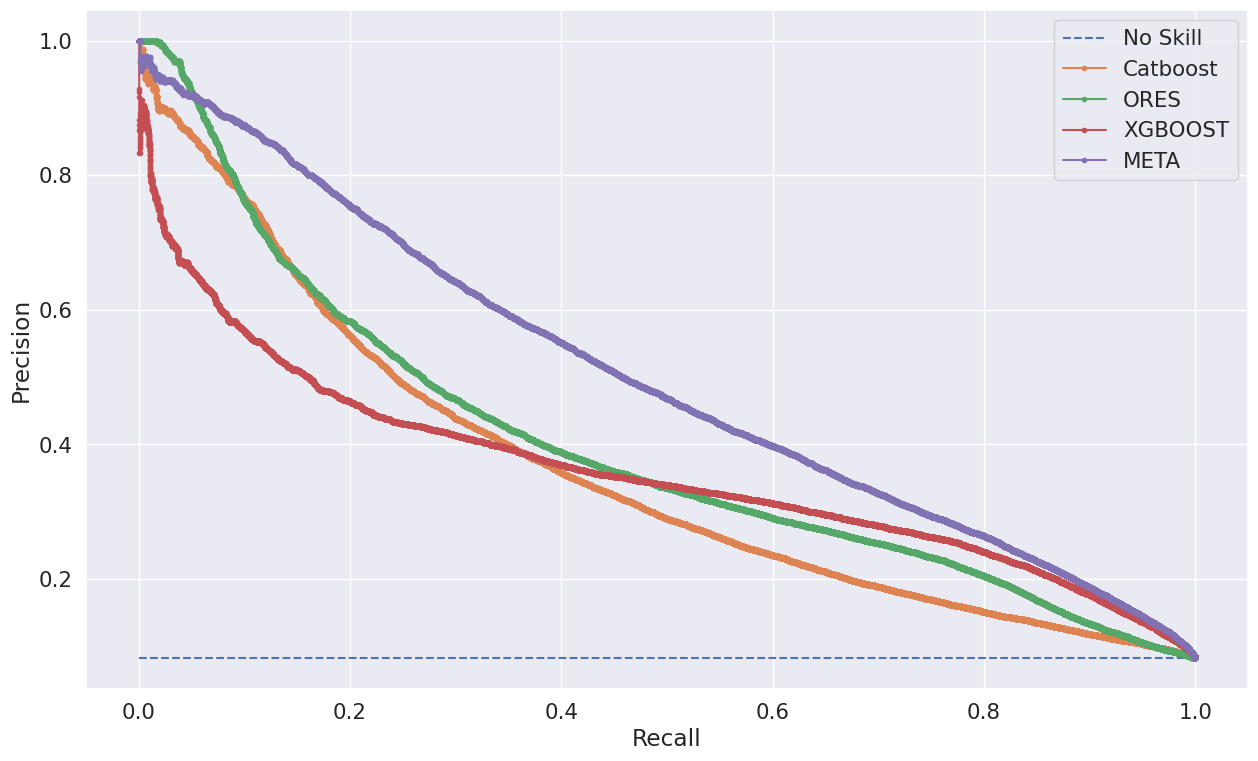

In [135]:
figure(figsize=(15, 9), dpi=100)
precision_recall_plot(test)

In [136]:
pd.DataFrame({'feature_importance': model.get_feature_importance(test_data), 
              'feature_names': features}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(30)

,feature_importance,feature_names
116,31.124447,xgb_pred
117,18.643644,catboost_pred
1,4.935345,revision_text_bytes_diff
115,4.061333,bert_title_score
0,3.507389,wiki_db
111,2.898426,bert_comment_s0
12,1.677582,insert_Category
112,1.605089,bert_comment_s1
5,1.385110,is_wikieditor
20,1.261126,insert_ExternalLink
